# Confronto tra DGF-PT2 e DGV-PT2 con dataset DGV
In questo esperimento sono confrontati i modelli DGF-PT2 e DGV-PT2 per la previsione su dataset a griglia variabile.

Per il modello DGF-PT2, viene preprocessato il dato di ingresso: il numero di nodi reale viene diviso per il rapporto tra l'area della griglia variabile e l'area della griglia fissa: ad esempio, se si vuole prevedere il tempo di esecuzione di una griglia che è il doppio di quella fissa, basta dividere per due il numero di nodi usati. Ovviamente, questa è una approssimazione: i calcoli sono fatti in parallelo per ogni nodo, ma i sottodomini contigui devono comunicare i risultati attraverso passaggio di messaggi (e quindi ci saranno in realtà un numero maggiore di comunicazioni in una griglia più ampia).

Per la previsione con modello DGF-PT2, il numero di nodi di input è quindi modificato usando la seguente formula

    n_nodes = n_nodes * fixed_grid_area / (x_length * y_length)
    
Dove `fixed_grid_area` è appunto l'area della griglia fissa usata per addestrare DGF-PT2.

Nel caso in cui il modello DGF-PT2 fosse sufficientemente preciso, si potrebbe lavorare esclusivamente su esperimenti generati a partire da una griglia fissa: questo permetterebbe di raccogliere molti più dati permettendo comunque previsioni su una griglia variabile.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
import os.path
sns.set_theme(style="whitegrid")

train_dgf_df = pd.read_csv("data/input/DGF_PT2_train.csv")
train_dgv_df = pd.read_csv("data/input/DGV_PT2_train.csv")
test_dgv_df = pd.read_csv("data/input/DGV_PT2_test.csv")

In [2]:
test_res_dgv_file = "data/output/DGV_PT2_test_result.csv"

if os.path.exists(test_res_dgv_file):
    print("Carico i risultati del modello da file")
else:
    with open("data/hpopt/DGV_PT2.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_dgv_df, None, test_dgv_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_dgv = model.fit(data, best_epoch)
    test_res_dgv = model.test(data)
    test_res_dgv.to_csv(test_res_dgv_file, index=False)
    
test_res_dgv = pd.read_csv(test_res_dgv_file)

Carico i risultati del modello da file


In [3]:
test_res_dgf_file = "data/output/DGF_PT2_DGV_test_result.csv"
test_dgf_df = test_dgv_df.copy()
test_dgf_df["n_nodes"] = test_dgf_df["n_nodes"] * 10000**2 / (test_dgf_df["x_length"] * test_dgf_df["y_length"])
test_dgf_df = test_dgf_df.drop(["x_length", "y_length"], axis=1)

if os.path.exists(test_res_dgf_file):
    print("Carico i risultati del modello da file")
else:
    with open("data/hpopt/DGF_PT2.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_dgf_df, None, test_dgf_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_dgf = model.fit(data, best_epoch)
    test_res_dgf = model.test(data)
    test_res_dgf.to_csv(test_res_dgf_file, index=False)
    
test_res_dgf = pd.read_csv(test_res_dgf_file)

Carico i risultati del modello da file


In [4]:
test_res_dgv["abs_err"] = (test_res_dgv.target - test_res_dgv.prediction).abs()
test_res_dgv["rel_err"] = test_res_dgv.abs_err / test_res_dgv.target
test_res_dgv["residual"] = test_res_dgv.target - test_res_dgv.prediction
test_res_dgv[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,0.810051,0.035090
std,2.140233,0.058846
min,0.000285,0.000019
25%,0.065549,0.009631
50%,0.184035,0.021104
75%,0.613838,0.037264
max,39.810120,0.618901


In [5]:
test_res_dgf["abs_err"] = (test_res_dgf.target - test_res_dgf.prediction).abs()
test_res_dgf["rel_err"] = test_res_dgf.abs_err / test_res_dgf.target
test_res_dgf["residual"] = test_res_dgf.target - test_res_dgf.prediction
test_res_dgf[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,1000.000000,1000.000000
mean,7.027280,0.189660
std,21.231832,0.162453
min,0.000792,0.000085
25%,0.326417,0.037477
50%,0.986844,0.161025
75%,3.101913,0.306720
max,224.901993,0.713366


In [6]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE DGF-PT2: 7.027280062198639
MAE DGV-PT2: 0.8100514325499535


In [7]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE DGF-PT2: 22.354475683639667
RMSE DGV-PT2: 2.287400620429122


In [8]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE DGF-PT2: 18.966036836233872
MAPE DGV-PT2: 3.5090211586246784


Dalla correlazione tra tempo osservato e tempo previsto, possiamo notare come la previsione degradi all'aumentare del tempo di esecuzione.

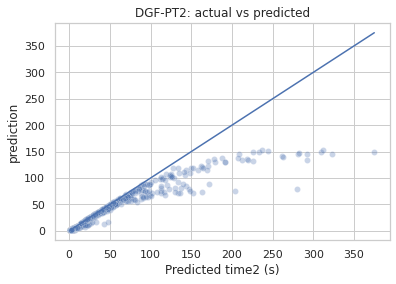

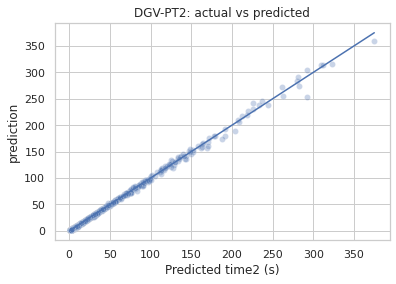

In [9]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    sns.scatterplot(x=df.target, y=df.prediction, alpha=0.3)
    plt.plot([df.target.min(), df.target.max()], [df.target.min(), df.target.max()])
    plt.title(f"{name}: actual vs predicted")
    plt.xlabel("Actual time2 (s)")
    plt.xlabel("Predicted time2 (s)")
    plt.show()

La relazione lineare tra tempo di esecuzione e errore è ancora più evidente nei grafici di correlazione tra tempo osservato e errore assoluto/relativo.

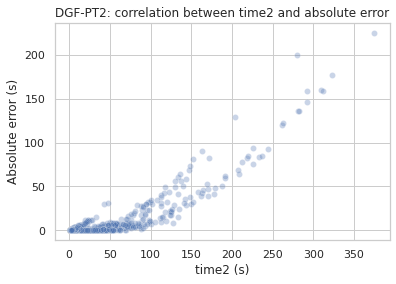

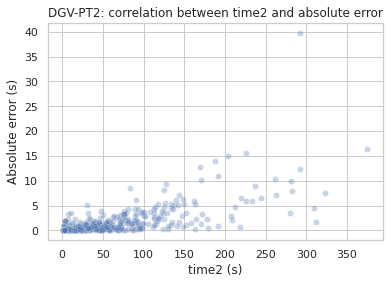

In [10]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    sns.scatterplot(x=df.target, y=df.abs_err, alpha=0.3)
    plt.title(f"{name}: correlation between time2 and absolute error")
    plt.xlabel("time2 (s)")
    plt.ylabel("Absolute error (s)")
    plt.show()

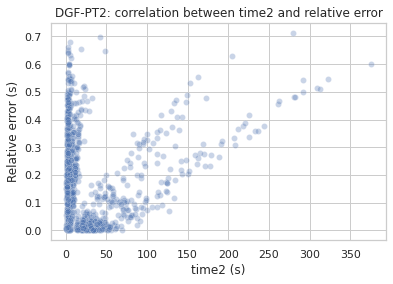

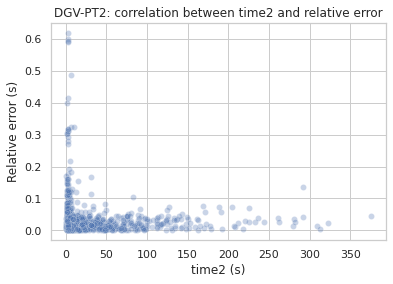

In [11]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    sns.scatterplot(x=df.target, y=df.rel_err, alpha=0.3)
    plt.title(f"{name}: correlation between time2 and relative error")
    plt.xlabel("time2 (s)")
    plt.ylabel("Relative error (s)")
    plt.show()

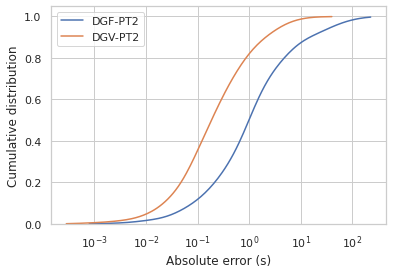

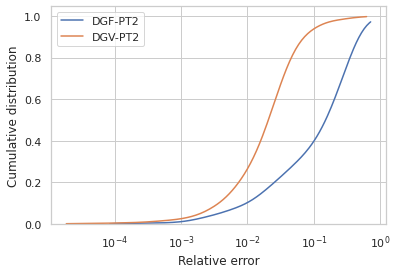

In [12]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    sns.kdeplot(data=df, x="abs_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.show()

for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    sns.kdeplot(data=df, x="rel_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.show()

Ovviamente, se prendiamo in considerazione solo le previsioni sulla griglia fissa, i due modelli hanno prestazioni analoghe.

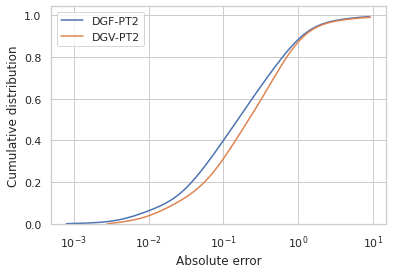

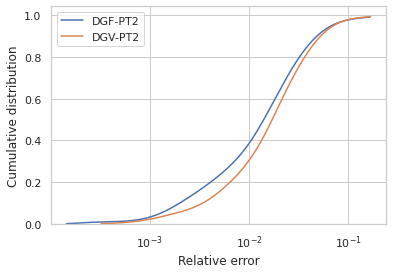

In [13]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    df = pd.concat([test_dgv_df, df], axis=1)
    sns.kdeplot(data=df.query("x_length == 10000 and y_length==10000"), x="abs_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error")
plt.ylabel("Cumulative distribution")
plt.show()

for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    df = pd.concat([test_dgv_df, df], axis=1)
    sns.kdeplot(data=df.query("x_length == 10000 and y_length == 10000"), x="rel_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.show()

Le peggiori prestazioni del modello DGF-PT1-V sono da imputarsi parzialmente al fatto che l'ipotesi di partenza è una approssimazione. Tuttavia, l'errore maggiore è presente per i job che hanno un valore del nodo normalizzato fuori dal range considerato per l'addestramento (cioè < 10). Considerando solo i job che hanno un numero di nodi normalizzati maggiore di 10, le prestazioni di DGF-PT1-V sono migliori.

In [14]:
df = pd.concat([test_dgf_df, test_res_dgf], axis=1)

In [15]:
df["n_nodes_orig"] = test_dgv_df.n_nodes
df["x_length"] = test_dgv_df.x_length
df["y_length"] = test_dgv_df.y_length

Qui possiamo vedere come la maggior parte delle predizioni con errore relativo > 10% sono per job nodi normalizzati < 10.

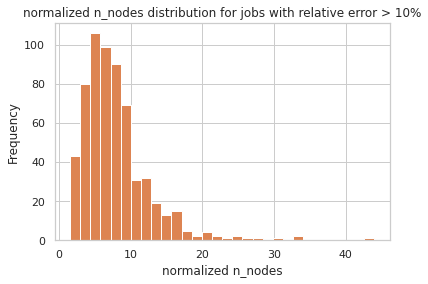

In [16]:
df.query("rel_err > 0.1").n_nodes.plot.hist(bins=30)
df.query("rel_err > 0.1").n_nodes.plot.hist(bins=30)
plt.title("normalized n_nodes distribution for jobs with relative error > 10%")
plt.xlabel("normalized n_nodes")
plt.savefig("tex/images/dgf-pt2-v/normalized_n_nodes_relerr_gt_10_dist.pdf")
plt.show()

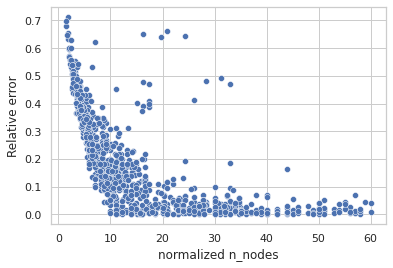

In [17]:
sns.scatterplot(data=df, x="n_nodes", y="rel_err")
plt.xlabel("normalized n_nodes")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgf-pt2-v/normalized_n_nodes_relerr_scatterplot.pdf")
plt.show()

MAE e MAPE di DGF-PT2-V per le previsioni dei job con nodi normalizzati maggiori di 10 sono sempre peggiori di DGV-PT2 (errore relativo e assoluto sono rispettivamente il doppio e il triplo), ma il rapporto è molto ridimensionato rispetto a quello complessivo.

In [18]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    print(f"MAE  {name}: ", x.abs_err.mean())
    
print()
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    x["n_nodes_2"] = test_dgf_df.n_nodes
    print(f"MAE  {name} (nodi > 10): ", x.query("n_nodes_2 >= 10").abs_err.mean())

    
print()
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    x["n_nodes_2"] = test_dgf_df.n_nodes
    print(f"MAE  {name} (nodi > 10 e griglia non fissa): ", x.query("n_nodes_2 >= 10 and x_length != 10000 and y_length != 10000").abs_err.mean())
    
print()
for name, df in zip(("DGF-PT2-V", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    print(f"RMSE  {name}: ", np.sqrt((x.abs_err**2).mean()))
    
print()
for name, df in zip(("DGF-PT2-V", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    x["n_nodes_2"] = test_dgf_df.n_nodes
    print(f"RMSE  {name} (nodi > 10): ", np.sqrt((x.query("n_nodes_2 >= 10")**2).abs_err.mean()))
    
print()
for name, df in zip(("DGF-PT2-V", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    x["n_nodes_2"] = test_dgf_df.n_nodes
    print(f"RMSE  {name} (nodi > 10 e griglia non fissa): ", np.sqrt((x.query("n_nodes_2 >= 10 and x_length != 10000 and y_length != 10000")**2).abs_err.mean()))
    
print()
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    print(f"MAPE  {name}: ", x.rel_err.mean())

print()    
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    x["n_nodes_2"] = test_dgf_df.n_nodes
    print(f"MAPE  {name} (nodi > 10): ", x.query("n_nodes_2 >= 10").rel_err.mean())    
    
print()    
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    x = pd.concat([test_dgv_df, df], axis=1)
    x["n_nodes_2"] = test_dgf_df.n_nodes
    print(f"MAPE  {name} (nodi > 10 e griglia non fissa): ", x.query("n_nodes_2 >= 10 and x_length != 10000 and y_length != 10000").rel_err.mean()) 

MAE  DGF-PT2:  7.027280062198639
MAE  DGV-PT2:  0.8100514325499535

MAE  DGF-PT2 (nodi > 10):  1.366875402950773
MAE  DGV-PT2 (nodi > 10):  0.535535273248074

MAE  DGF-PT2 (nodi > 10 e griglia non fissa):  2.0566931016185657
MAE  DGV-PT2 (nodi > 10 e griglia non fissa):  0.579331738405487

RMSE  DGF-PT2-V:  22.354475683639667
RMSE  DGV-PT2:  2.287400620429122

RMSE  DGF-PT2-V (nodi > 10):  2.680714859835948
RMSE  DGV-PT2 (nodi > 10):  1.0212600416887965

RMSE  DGF-PT2-V (nodi > 10 e griglia non fissa):  3.426195170381031
RMSE  DGV-PT2 (nodi > 10 e griglia non fissa):  1.003925812830919

MAPE  DGF-PT2:  0.18966036836233874
MAPE  DGV-PT2:  0.03509021158624678

MAPE  DGF-PT2 (nodi > 10):  0.07840195045649305
MAPE  DGV-PT2 (nodi > 10):  0.03826142834734554

MAPE  DGF-PT2 (nodi > 10 e griglia non fissa):  0.12167670126018715
MAPE  DGV-PT2 (nodi > 10 e griglia non fissa):  0.049666939437139374


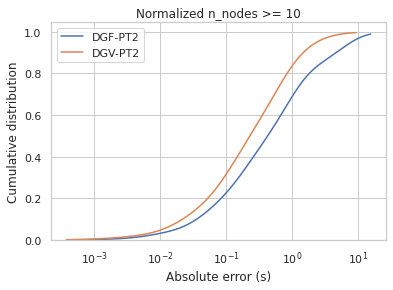

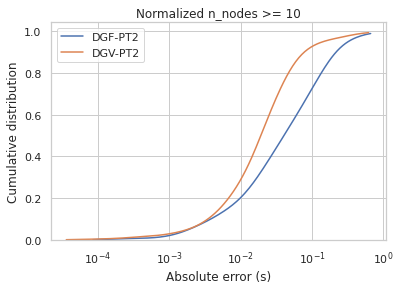

In [19]:
for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    df = pd.concat([test_dgv_df, df], axis=1)
    df["n_nodes_2"] = test_dgf_df.n_nodes
    sns.kdeplot(data=df.query("n_nodes_2 >= 10"), x="abs_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.title("Normalized n_nodes >= 10")
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pt2-v/cdf-errore-assoluto-nn-ge-10.pdf")
plt.show()

for name, df in zip(("DGF-PT2", "DGV-PT2"), (test_res_dgf, test_res_dgv)):
    df = pd.concat([test_dgv_df, df], axis=1)
    df["n_nodes_2"] = test_dgf_df.n_nodes
    sns.kdeplot(data=df.query("n_nodes_2 >= 10"), x="rel_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.title("Normalized n_nodes >= 10")
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pt2-v/cdf-errore-relativo-nn-ge-10.pdf")
plt.show()

## Conclusioni
DGV-PT1 è poco più preciso rispetto a DGF-PT1-V, anche se limitato al range dei nodi in cui sono stati addestrati: la causa della minore precisione è l'impossibilità di poter rappresentare il ritardo introdotto dal maggior numero di messaggi scambiati a causa della maggiore area di una griglia e/o dalla sua forma (in quanto il numero di messaggi dipende anche dal perimetro). Tuttavia, anche DGF-PT1-V ha una precisione sufficiente da poter essere usata come previsore. L'unico accorgimento è che si deve estendere il limite inferiore dei nodi di cui raccogliere esperimenti, in quanto all'allontanarsi dall'estremo inferiore del numero di nodi su cui è stato addestrato peggiora proporzialmente la sua accuratezza. Al tempo stesso, raccogliere dati per il dataset a griglia fissa è meno complesso e oneroso, in quanto si possono ignorare due dimensione (`x_length` e `y_length`).